## DDQN in Simpler Environments

Base DQN implementation adapted from HW7

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from ..DDQN import DQNAgent
from ..DDQN import DDQNAgent

ImportError: attempted relative import with no known parent package

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [5]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action/(self.bins-1.0)*(self.orig_action_space.high-self.orig_action_space.low)  

## DQN
Test DQN implementation on simple environments

### Pendulum

In [4]:
RENDER = False
ENV_NAME = 'Pendulum-v1'

if RENDER:
    env = gym.make(ENV_NAME, render_mode='human')
else:
    env = gym.make(ENV_NAME)

if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print("Env. action space:")
print(ac_space)
print("Env. observation space:")
print(o_space)
#print(list(zip(env.observation_space.low, env.observation_space.high)))

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


In [ ]:
DISCOUNT = 0.95
EPS = 0.2

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=DISCOUNT,
    eps=EPS
)


In [7]:
ob, _info = env.reset()
q_agent.Q.predict(ob)

array([ 0.09805331,  0.36470813, -0.09406217,  0.15868868,  0.1882916 ],
      dtype=float32)

In [8]:
MAX_EPISODES=600
MAX_STEPS=500

#PRINT_FREQ=20
PRINT_FREQ=MAX_EPISODES

In [9]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    # print("Starting a new episode")
    total_reward = 0
    ob, _info = env.reset()
    for t in range(MAX_STEPS):
        done = False
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if (i-1) % PRINT_FREQ == 0:
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

  0%|          | 0/600 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -3331.505158883263


In [10]:
env.close()

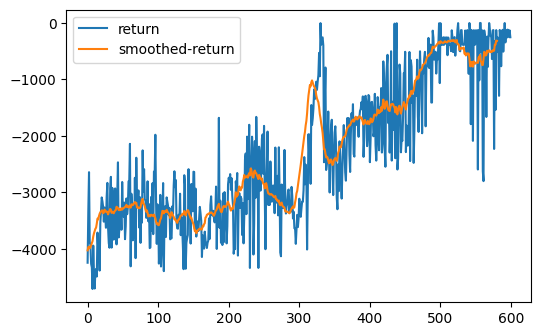

In [11]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

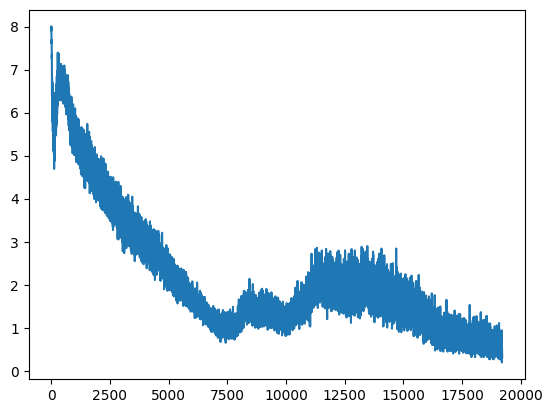

In [12]:
plt.figure()
plt.plot(losses_np)

In [13]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')
ob, _info = env.reset()
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space

env.reset()
total_reward = 0
for t in range(500):
    a = q_agent.act(ob)
    (ob, reward, done, trunc, _info) = env.step(a)
    total_reward+= reward
    if done or trunc: break

print("Total reward:", total_reward)

Total reward: -119.16370755144287


In [14]:
env.close()

### LunarLander

In [25]:
RENDER = False
ENV_NAME = 'LunarLander-v3'

if RENDER:
    env = gym.make(ENV_NAME, render_mode='human')
else:
    env = gym.make(ENV_NAME)

if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print("Env. action space:")
print(ac_space)
print("Env. observation space:")
print(o_space)
#print(list(zip(env.observation_space.low, env.observation_space.high)))

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [26]:
DISCOUNT = 0.95
#EPS = 0.2
EPS = 0.4

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=DISCOUNT,
    eps=EPS,
)

In [27]:
ob, _info = env.reset()
q_agent.Q.predict(ob)

array([-0.067747  , -0.03205168, -0.01657432,  0.14588133], dtype=float32)

In [28]:
MAX_EPISODES=1000
MAX_STEPS=600

#PRINT_FREQ=20
PRINT_FREQ=MAX_EPISODES

In [30]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    # print("Starting a new episode")
    total_reward = 0
    ob, _info = env.reset()
    for t in range(MAX_STEPS):
        done = False
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if (i-1) % PRINT_FREQ == 0:
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 213 steps. Reward: -221.5997762795502


In [31]:
env.close()

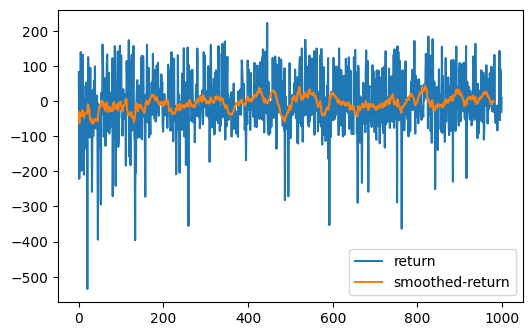

In [32]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

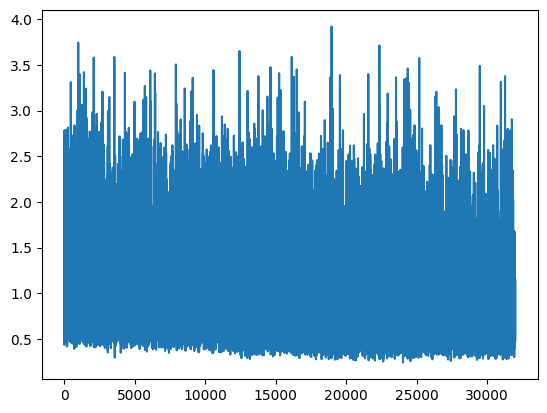

In [33]:
plt.figure()
plt.plot(losses_np)

In [34]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')
ob, _info = env.reset()
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space

env.reset()
total_reward = 0
for t in range(500):
    a = q_agent.act(ob)
    (ob, reward, done, trunc, _info) = env.step(a)
    total_reward+= reward
    if done or trunc: break

print("Total reward:", total_reward)

Total reward: 151.79726274020408


In [35]:
env.close()

## DDQN

Test DDQN implementation on simple environments

### Pendulum

In [6]:
RENDER = False
ENV_NAME = 'Pendulum-v1'

if RENDER:
    env = gym.make(ENV_NAME, render_mode='human')
else:
    env = gym.make(ENV_NAME)

if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print("Env. action space:")
print(ac_space)
print("Env. observation space:")
print(o_space)
#print(list(zip(env.observation_space.low, env.observation_space.high)))

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


In [7]:
DISCOUNT = 0.95
EPS = 0.2
UDPATE_TARGET_FREQ = 20
TAU = 1e-3

q_agent = DDQNAgent(
    o_space,
    ac_space,
    discount=DISCOUNT,
    eps=EPS,
    update_target_every=UDPATE_TARGET_FREQ,
    tau=TAU
)

In [8]:
ob, _info = env.reset()
q_agent.Q.predict(ob)

array([-0.05355823,  0.00793748,  0.20045286,  0.2143381 , -0.06709563],
      dtype=float32)

In [9]:
MAX_EPISODES=600
MAX_STEPS=500

#PRINT_FREQ=20
PRINT_FREQ=MAX_EPISODES

In [10]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    # print("Starting a new episode")
    total_reward = 0
    ob, _info = env.reset()
    for t in range(MAX_STEPS):
        done = False
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward += reward
        q_agent.store_transition((ob, a, reward, ob_new, done))        
        ob = ob_new
        if done:
            break
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])
    
    if (i-1) % PRINT_FREQ == 0:
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

  0%|          | 0/600 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -4310.813941040309


In [11]:
env.close()

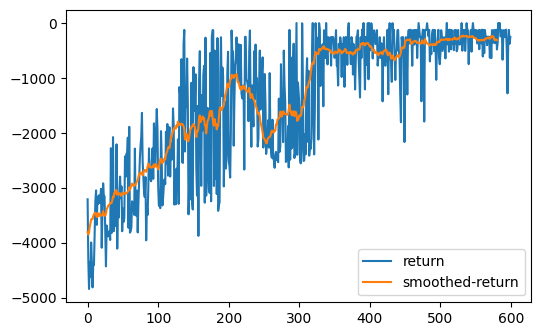

In [12]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

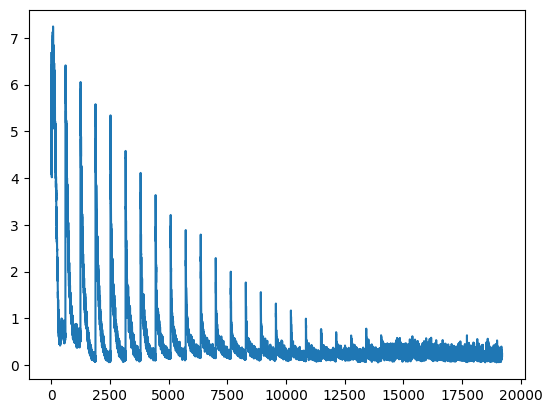

In [13]:
plt.figure()
plt.plot(losses_np)

In [14]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')
ob, _info = env.reset()
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space

env.reset()
total_reward = 0
for t in range(500):
    a = q_agent.act(ob)
    (ob, reward, done, trunc, _info) = env.step(a)
    total_reward+= reward
    if done or trunc: break

print("Total reward:", total_reward)

Total reward: -127.1810035163133


In [15]:
env.close()

### LunarLander

In [6]:
RENDER = False
ENV_NAME = 'LunarLander-v3'

if RENDER:
    env = gym.make(ENV_NAME, render_mode='human')
else:
    env = gym.make(ENV_NAME)

if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print("Env. action space:")
print(ac_space)
print("Env. observation space:")
print(o_space)
#print(list(zip(env.observation_space.low, env.observation_space.high)))

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [7]:
DISCOUNT = 0.95
EPS = 0.2
UDPATE_TARGET_FREQ = 20
TAU = 1e-3

q_agent = DDQNAgent(
    o_space,
    ac_space,
    discount=DISCOUNT,
    eps=EPS,
    update_target_every=UDPATE_TARGET_FREQ,
    tau=TAU
)

In [8]:
ob, _info = env.reset()
q_agent.Q.predict(ob)

array([ 0.13052641,  0.05384073,  0.10922448, -0.15995419], dtype=float32)

In [9]:
MAX_EPISODES=1000
MAX_STEPS=600

#PRINT_FREQ=20
PRINT_FREQ=MAX_EPISODES

In [10]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    # print("Starting a new episode")
    total_reward = 0
    ob, _info = env.reset()
    for t in range(MAX_STEPS):
        done = False
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if (i-1) % PRINT_FREQ == 0:
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 87 steps. Reward: -202.60508581564056


In [21]:
env.close()

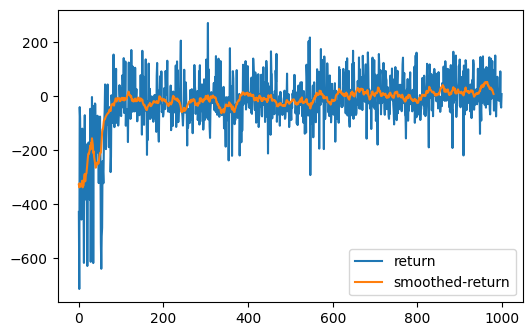

In [22]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

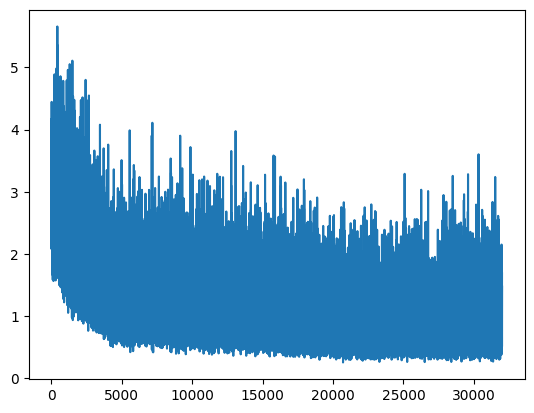

In [23]:
plt.figure()
plt.plot(losses_np)

In [28]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')
ob, _info = env.reset()
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space

env.reset()
total_reward = 0
for t in range(500):
    a = q_agent.act(ob)
    (ob, reward, done, trunc, _info) = env.step(a)
    total_reward+= reward
    if done or trunc: break

print("Total reward:", total_reward)

Total reward: 108.59719870007558


In [29]:
env.close()